**Названия столбцов с пояснениями**

age — возраст клиента (числовой).

job — тип занятости (категориальный: admin., unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services).

marital — семейное положение (категориальный: married, divorced, single).

education — уровень образования (категориальный: unknown, primary, secondary, tertiary).

default — есть ли дефолт по кредиту (категориальный: yes / no).

balance — средний годовой баланс на счёте, евро (числовой; может быть отрицательным — овердрафт).

housing — есть ли ипотека (категориальный: yes / no).

loan — есть ли потребкредит (категориальный: yes / no).

contact — тип контакта в текущей кампании (категориальный: unknown, telephone, cellular).

day — день месяца последнего контакта (числовой: 1–31).

month — месяц последнего контакта (категориальный: jan…dec).

duration — длительность последнего звонка, секунд (числовой).

campaign — число контактов в этой кампании с клиентом (числовой, включает последний звонок).

pdays — дней с последнего контакта в прошлой кампании (числовой; -1 — не контактировались ранее).

previous — число контактов до текущей кампании (числовой).

poutcome — результат предыдущей кампании (категориальный: unknown, other, failure, success).

y — таргет: подписался ли клиент на депозит (категориальный: yes / no; для модели обычно переводим в {1,0}).

In [1]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import seaborn as sns
from helper import *
from plots import *
import random

In [3]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [4]:
# Загружаем датасет в память
df = pd.read_csv("data.csv", sep=";")
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
# Смотрим на статистики по числовым переменным (категориальные сюда не входят)
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
# Подсчет числа дублированных строк
df.duplicated().sum() 

np.int64(0)

In [8]:
# выводим число пропущенных значений по каждому столбцу
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
df.select_dtypes(exclude=["number"]).columns.tolist()

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [10]:
df.nunique(dropna=True).rename("nunique")

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
Name: nunique, dtype: int64

### 2.3 Корректность по столбцам

In [11]:
# job — только допустимые значения?
df['job'].value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

In [12]:
# marital
df['marital'].value_counts()

marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

In [13]:
# education
df['education'].value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [14]:
# default / housing / loan
df['default'].value_counts(), df['housing'].value_counts(), df['loan'].value_counts()

(default
 no     44396
 yes      815
 Name: count, dtype: int64,
 housing
 yes    25130
 no     20081
 Name: count, dtype: int64,
 loan
 no     37967
 yes     7244
 Name: count, dtype: int64)

In [15]:
# contact
df['contact'].value_counts()

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

In [16]:
# month
df['month'].value_counts()

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

In [17]:
# poutcome
df['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [18]:
# таргет y
df['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [19]:
# balance — просто смотрим распределение/экстремы (отрицательные допустимы как овердрафт (клиент должен банку))
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [20]:
# day — должен быть 1..31
df['day'].describe()

count    45211.000000
mean        15.806419
std          8.322476
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64

In [21]:
# day — сколько вне диапазона [1, 31]
len(df[(df['day'] < 1) | (df['day'] > 31)])

0

In [22]:
# duration — не должна быть отрицательной
df['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [23]:
# duration — сколько < 0
len(df[df['duration'] < 0])

0

In [24]:
# campaign — хотя бы 1 контакт (и разумный верхний предел, например до 100)
df['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [25]:
# pdays — -1 означает "не контактировался ранее", иначе ожидаем >=0
df['pdays'].describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [26]:
# pdays — сколько значений < -1 (это подозрительно)
len(df[df['pdays'] < -1])

0

In [27]:
# previous — число прошлых контактов, ожидаем >=0
df['previous'].describe()

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

In [28]:
# previous — сколько < 0
len(df[df['previous'] < 0])

0

## 3. Детальное изучение признаков (и таргета)

### 3.1 Числовые переменные

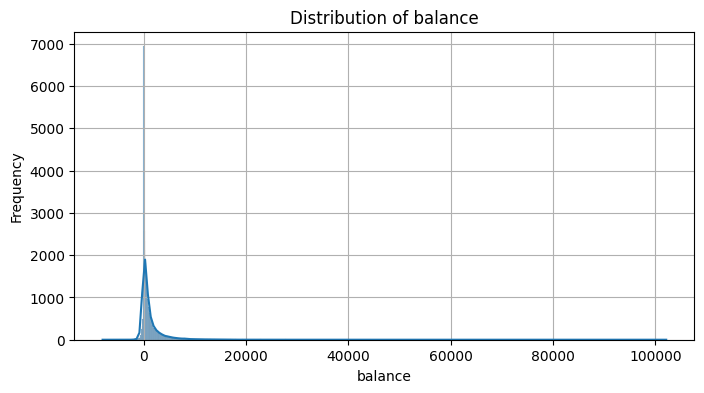

In [29]:
# Строим гистограмму распределения balance
plot_hist_numeric(df, 'balance')

Основная масса наблюдений сосредоточена около нуля (несколько тысяч евро в абсолюте), распределение резко правоскошенное с длинным хвостом до ~100 000. Отрицательные значения — допустимый овердрафт. Всё, что далеко в правом хвосте, — редкие наблюдения/возможные выбросы.

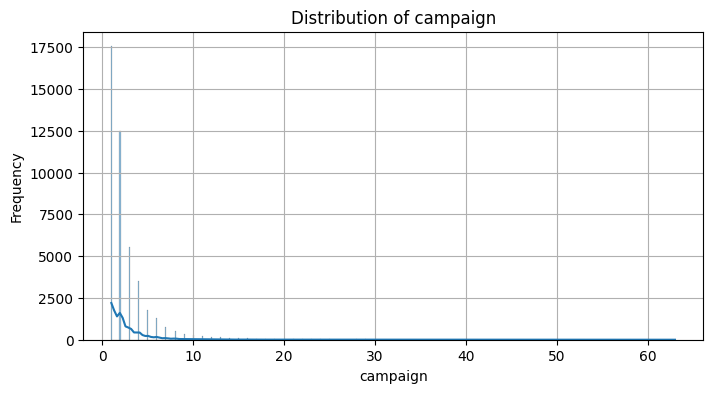

In [30]:
# Строим гистограмму распределения campaign
plot_hist_numeric(df, 'campaign')

Пик на 1–3 контактах; дальше частота быстро падает. Примерно до ~10 контактов — типичный диапазон; значения >30 встречаются редко, >60 — экстремальные. разумно рассматривать биннинг

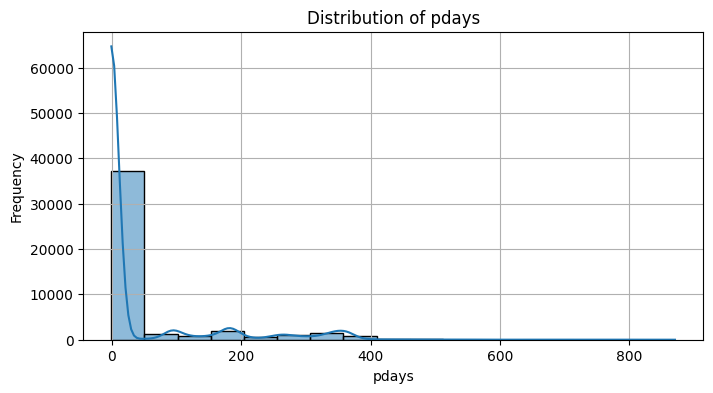

In [31]:
# Строим гистограмму распределения campaign
plot_hist_numeric(df, 'pdays')

Большая часть наблюдений лежит в малых значениях (≈0–50 дней), далее видны «островки» на круглых значениях (≈100–400), что похоже на плановые волны дозвонов. Очень большие значения — редкие. специальное значение −1 означает не контактировались ранее.

In [32]:
# Доля -1 (не контактировался ранее) по столбцу pdays
pdays_s = pd.to_numeric(df['pdays'], errors='coerce')
share_minus1 = (pdays_s == -1).mean() * 100
print(f"Доля -1 (не контактировался ранее): {share_minus1:.2f}%  ({int((pdays_s == -1).sum())} из {len(pdays_s)})")

Доля -1 (не контактировался ранее): 81.74%  (36954 из 45211)


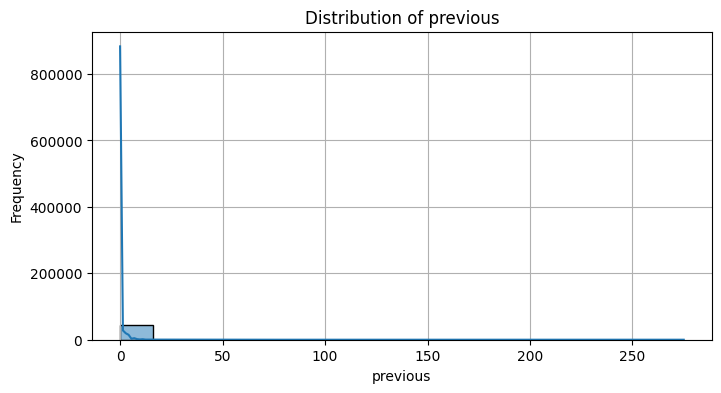

In [33]:
# Строим гистограмму распределения previous
plot_hist_numeric(df, 'previous')

Резкий пик на 0 (у большинства не было прошлых контактов), немного значений 1–5; далее длинный разреженный хвост. Значения >20 редки, >50 — экстремальные.

### 3.2 Категориальные переменные

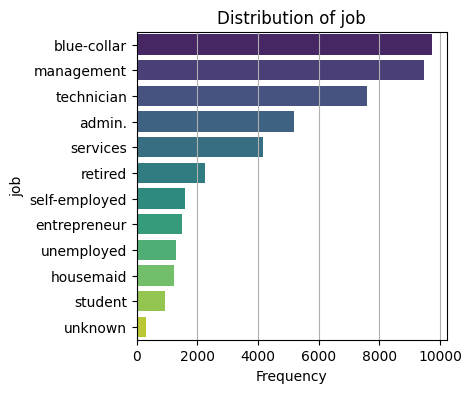

In [34]:
# Строим гистограмму распределения job
plot_hist_categorical(df, 'job')

Топ-3 по частоте: blue-collar, management, technician. unknown — минимальная доля.

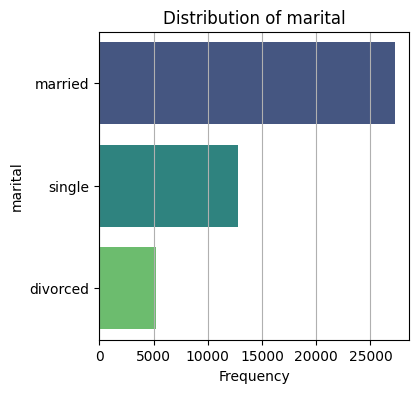

In [35]:
# Строим гистограмму распределения marital
plot_hist_categorical(df, 'marital')

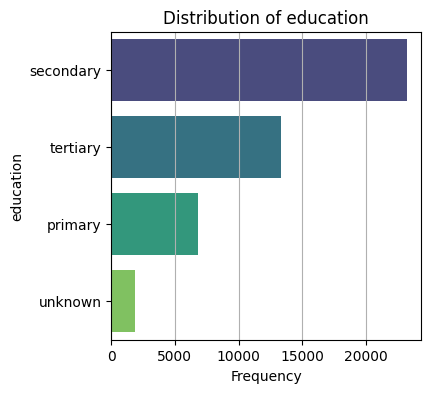

In [36]:
# Строим гистограмму распределения education
plot_hist_categorical(df, 'education')

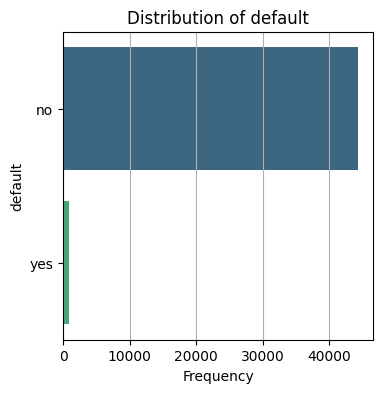

In [37]:
# Строим гистограмму распределения default
plot_hist_categorical(df, 'default')

Почти все — no, yes встречается очень редко (сильный дисбаланс).

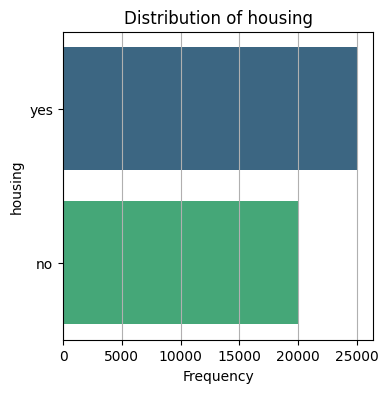

In [38]:
# Строим гистограмму распределения housing
plot_hist_categorical(df, 'housing')

Больше yes, чем no (ипотека у большинства).

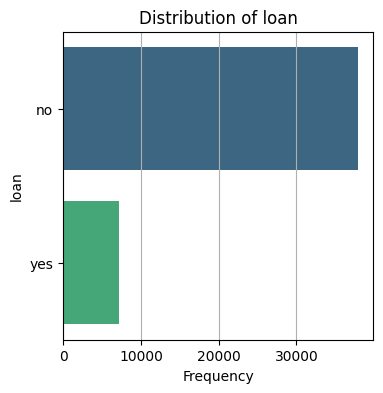

In [39]:
# Строим гистограмму распределения loan
plot_hist_categorical(df, 'loan')

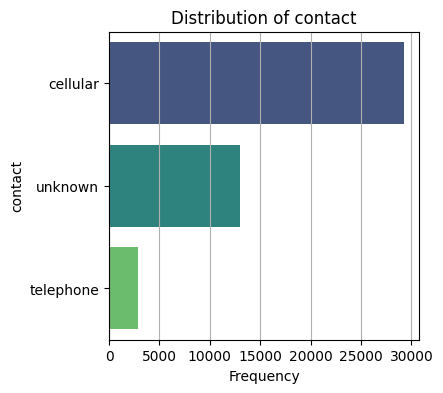

In [40]:
# Строим гистограмму распределения contact
plot_hist_categorical(df, 'contact')

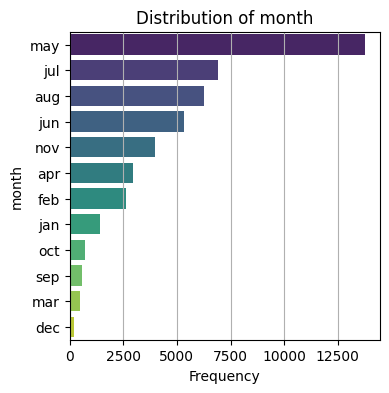

In [41]:
# Строим гистограмму распределения month
plot_hist_categorical(df, 'month')

Пик активности кампаний в may, затем jul/aug/jun; осень/зима представлены слабее. Важно учитывать временной порядок при валидации.

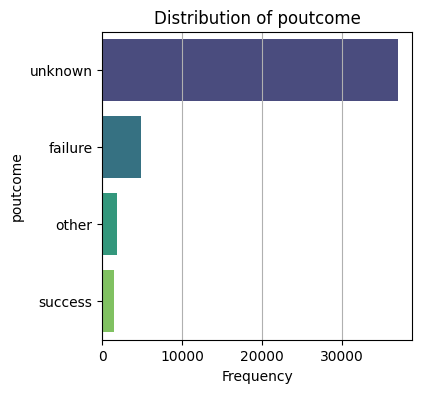

In [42]:
# Строим гистограмму распределения poutcome
plot_hist_categorical(df, 'poutcome')

Почти всё — unknown; из наблюдаемых исходов преобладает failure, success — очень редок.

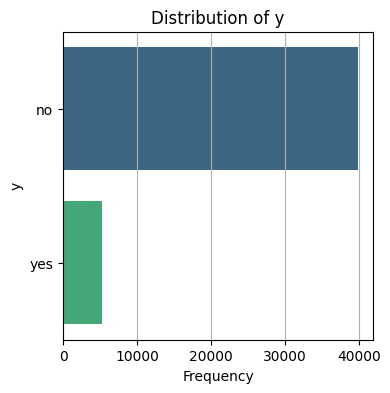

In [87]:
# Строим гистограмму распределения poutcome
plot_hist_categorical(df, 'y')

## 4. Изучение взаимосвязей между признаками

### 4.1 Общая матрица корреляций

interval columns not set, guessing: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


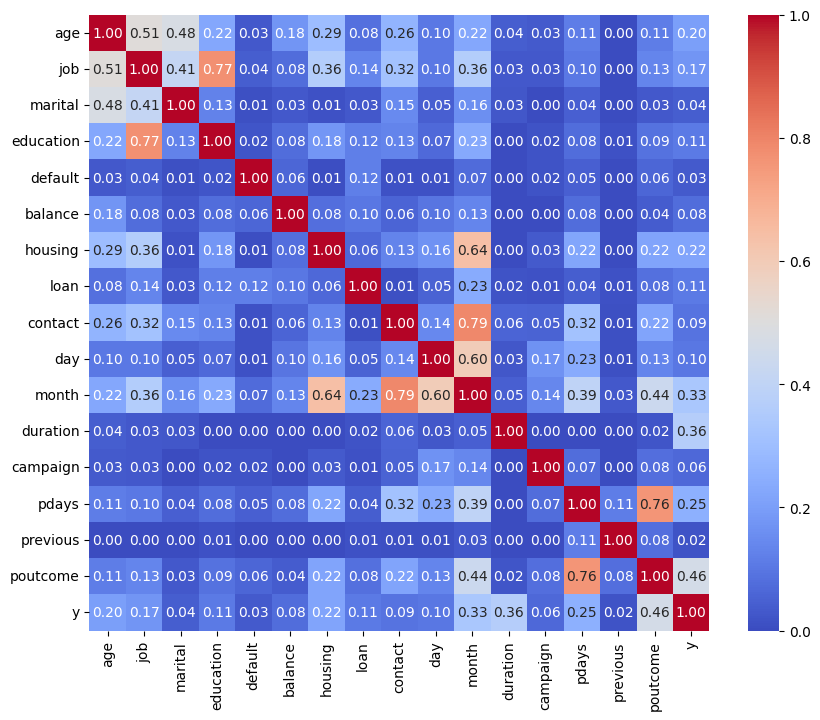

In [43]:
# поскольку в нашем датасете присутствуют категориальные признаки, используем корреляцию phik, которая способна с ними работать
plot_phik(df)

Самые сильные парные связи
- contact vs month = 0.79 — тип контакта сильно зависит от месяца кампании (сезонность каналов).
- pdays vs previous = 0.76 — чем дольше с прошлого контакта, тем больше прошлых контактов фиксировалось (логично по бизнес-процессу).
- job vs education = 0.77 — род занятости тесно связан с уровнем образования.
- day vs month = 0.60 

Связь признаков с таргетом y (по величине корреляции)
- poutcome → y = 0.46: успешность прошлой кампании — сильный предиктор подписки.
- duration → y = 0.36: длительность звонка заметно связана с целевым исходом — типичная утечка (она известна только после контакта).
- month → y = 0.33, contact → y = 0.25: выраженная сезонность и влияние канала связи.

### 4.2 Подробное изучение корреляций между выбранными парами

poutcome vs y

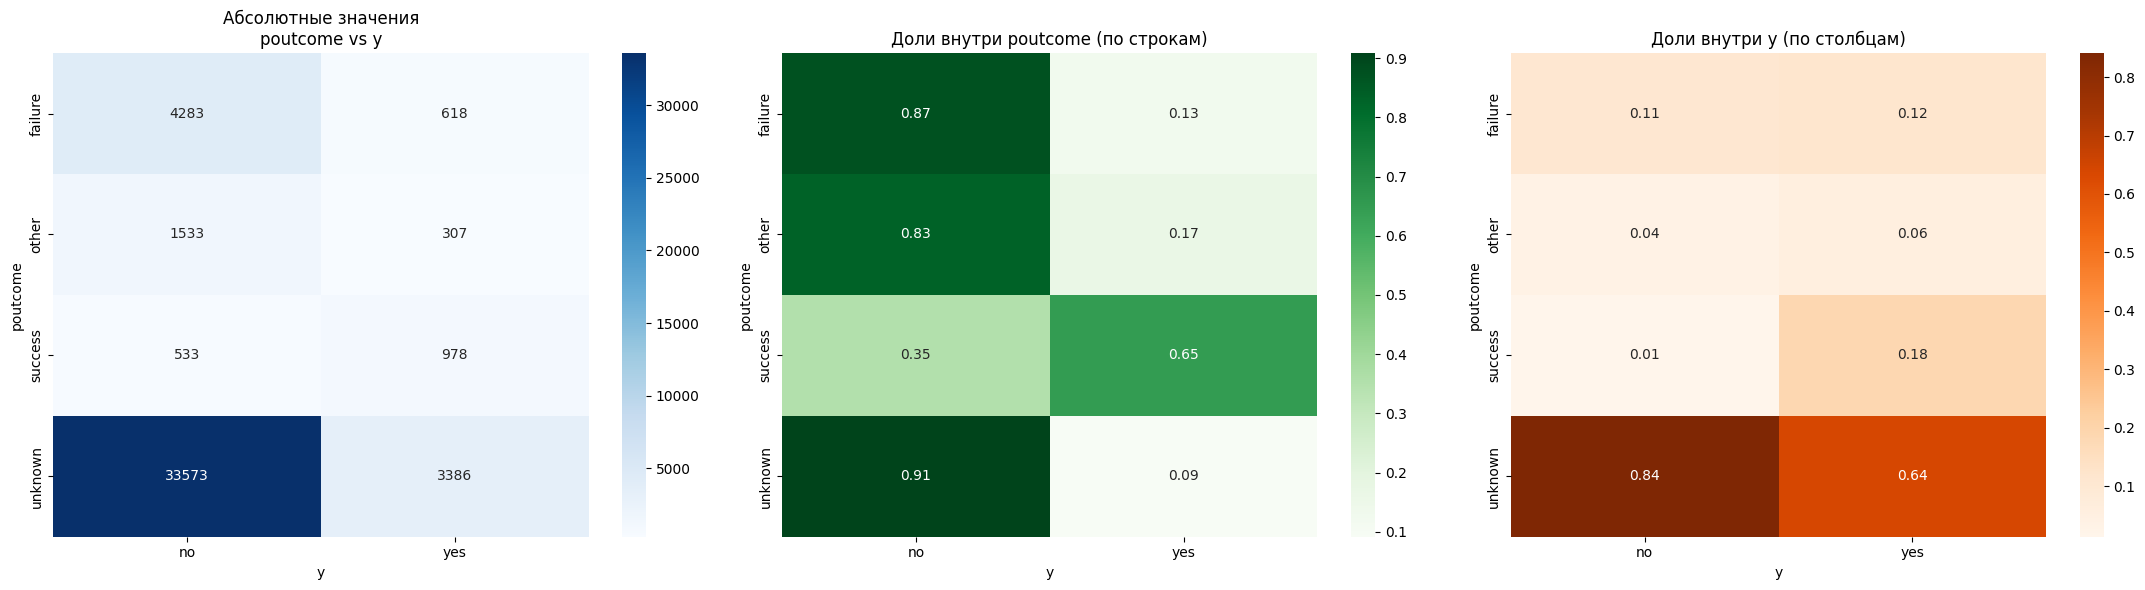

y,no,yes
poutcome,,
failure,0.874,0.126
other,0.833,0.167
success,0.353,0.647
unknown,0.908,0.092


Комментарий: при poutcome=success доля подписок ≈ 65%; при failure — 13%; при unknown — 9%.


In [44]:
plot_categorical_relationship(df, 'poutcome', 'y')

tab = pd.crosstab(df['poutcome'], df['y'], normalize='index').round(3)
display(tab)

def pct(a): return f"{a*100:.0f}%"
unk = tab.loc['unknown','yes'] if 'unknown' in tab.index else float('nan')
fail = tab.loc['failure','yes'] if 'failure' in tab.index else float('nan')
succ = tab.loc['success','yes'] if 'success' in tab.index else float('nan')

print(
    "Комментарий:",
    f"при poutcome=success доля подписок ≈ {pct(succ)};",
    f"при failure — {pct(fail)};",
    f"при unknown — {pct(unk)}.",
)

contact vs month (сезонность каналов)

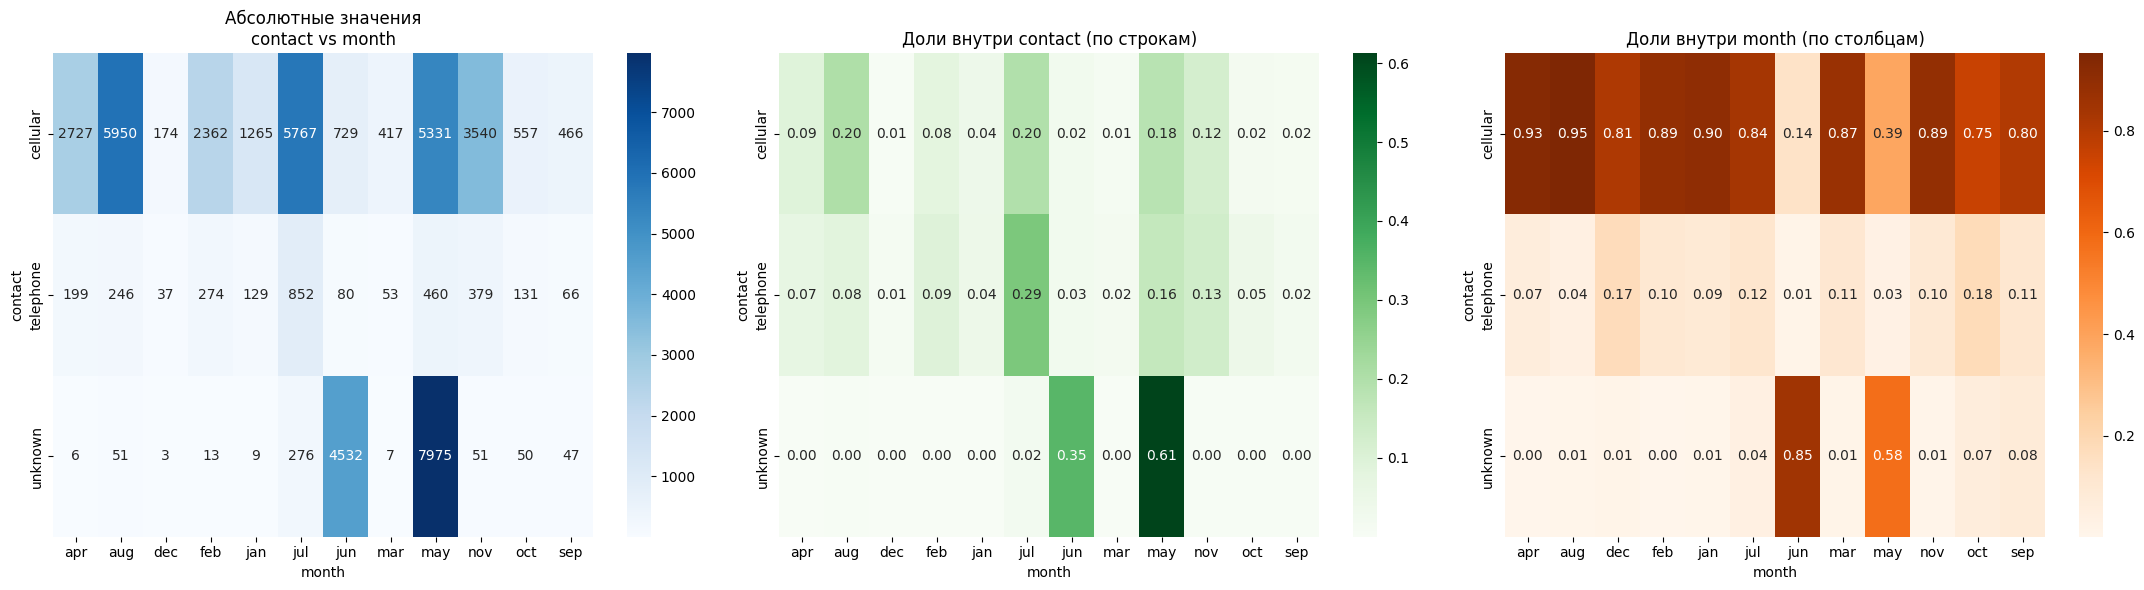

contact,cellular,telephone,unknown
month,,,
apr,0.930,0.068,0.002
aug,0.952,0.039,0.008
dec,0.813,0.173,0.014
feb,0.892,0.103,0.005
jan,0.902,0.092,0.006
jul,0.836,0.124,0.040
jun,0.136,0.015,0.849
mar,0.874,0.111,0.015
may,0.387,0.033,0.579


Комментарий: в may основной канал — unknown (58% от контактов этого месяца).
Комментарий: в jul основной канал — cellular (84% от контактов этого месяца).
Комментарий: в dec основной канал — cellular (81% от контактов этого месяца).


In [45]:
plot_categorical_relationship(df, 'contact', 'month')

tab = pd.crosstab(df['month'], df['contact'], normalize='index').round(3)
display(tab.head(12))

def p(val): return f"{val*100:.0f}%"
for m in ['may','jul','dec']:
    if m in tab.index:
        c_share = tab.loc[m].sort_values(ascending=False)
        top = c_share.index[0]; topv = c_share.iloc[0]
        print(f"Комментарий: в {m} основной канал — {top} ({p(topv)} от контактов этого месяца).")

job vs education (структура занятости по уровню образования)

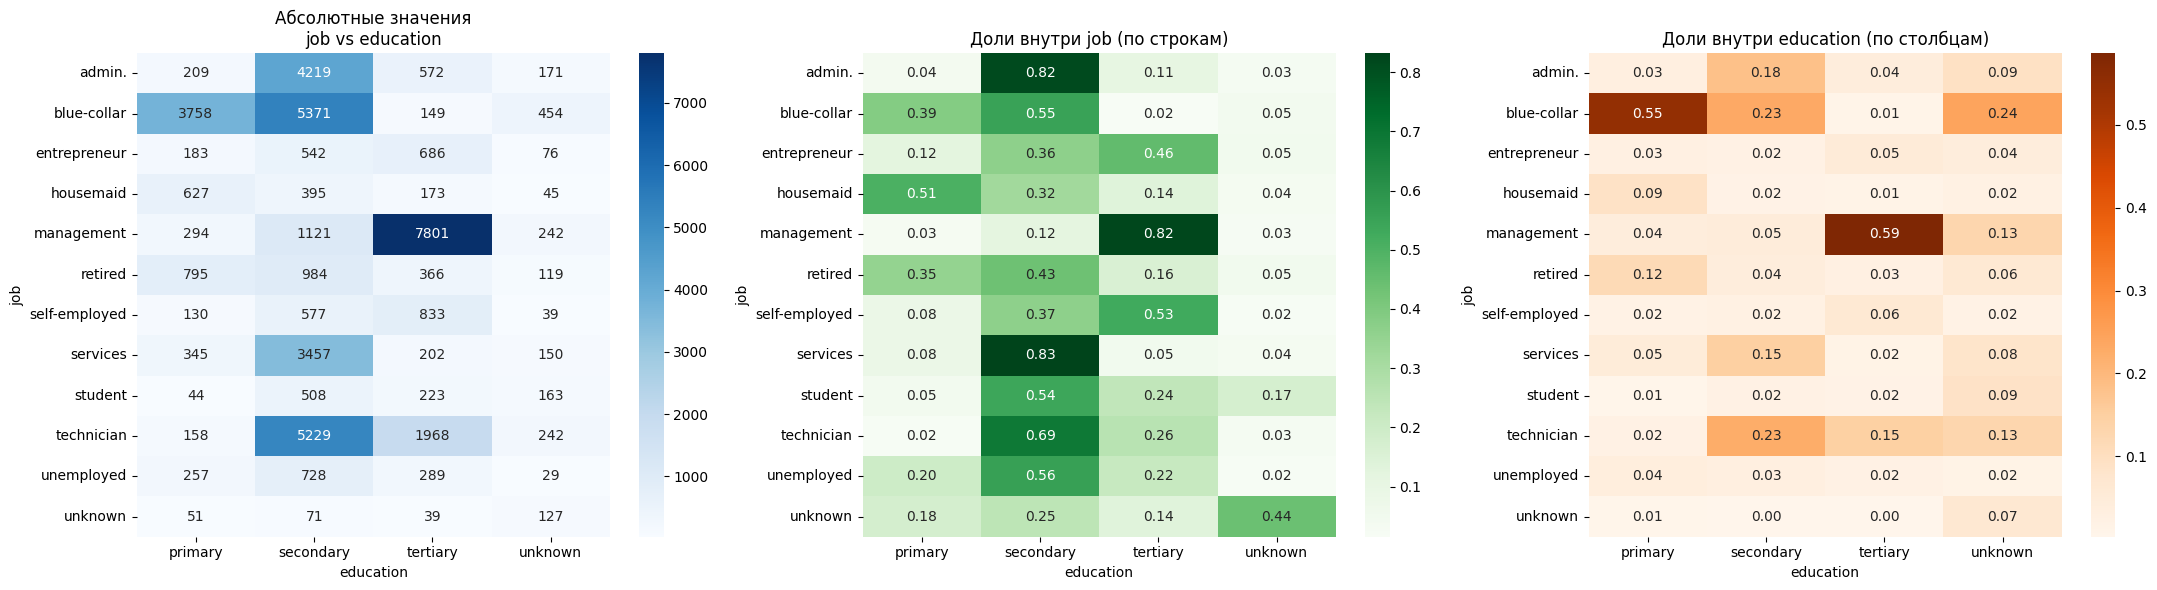

,top_education,share_%,n
job,,,
blue-collar,secondary,55.2,9732
management,tertiary,82.5,9458
technician,secondary,68.8,7597
admin.,secondary,81.6,5171
services,secondary,83.2,4154
retired,secondary,43.5,2264
self-employed,tertiary,52.8,1579
entrepreneur,tertiary,46.1,1487


Комментарий: для job=management доминирует образование tertiary (82.5 от группы).
Комментарий: для job=technician доминирует образование secondary (68.8 от группы).
Комментарий: для job=blue-collar доминирует образование secondary (55.2 от группы).
Комментарий: для job=admin. доминирует образование secondary (81.6 от группы).


In [46]:
plot_categorical_relationship(df, 'job', 'education')

ct_row = pd.crosstab(df['job'], df['education'], normalize='index')
ct_abs = pd.crosstab(df['job'], df['education'])
top_level = ct_row.idxmax(axis=1)
top_share = ct_row.max(axis=1).round(3)
summary = pd.DataFrame({
    'top_education': top_level,
    'share_%': (top_share*100).round(1),
    'n': ct_abs.sum(axis=1)
}).sort_values('n', ascending=False)
display(summary.head(8))

for j in ['management','technician','blue-collar','admin.']:
    if j in summary.index:
        print(f"Комментарий: для job={j} доминирует образование {summary.loc[j,'top_education']} "
              f"({summary.loc[j,'share_%']} от группы).")


housing vs loan (перекрёстная долговая нагрузка)

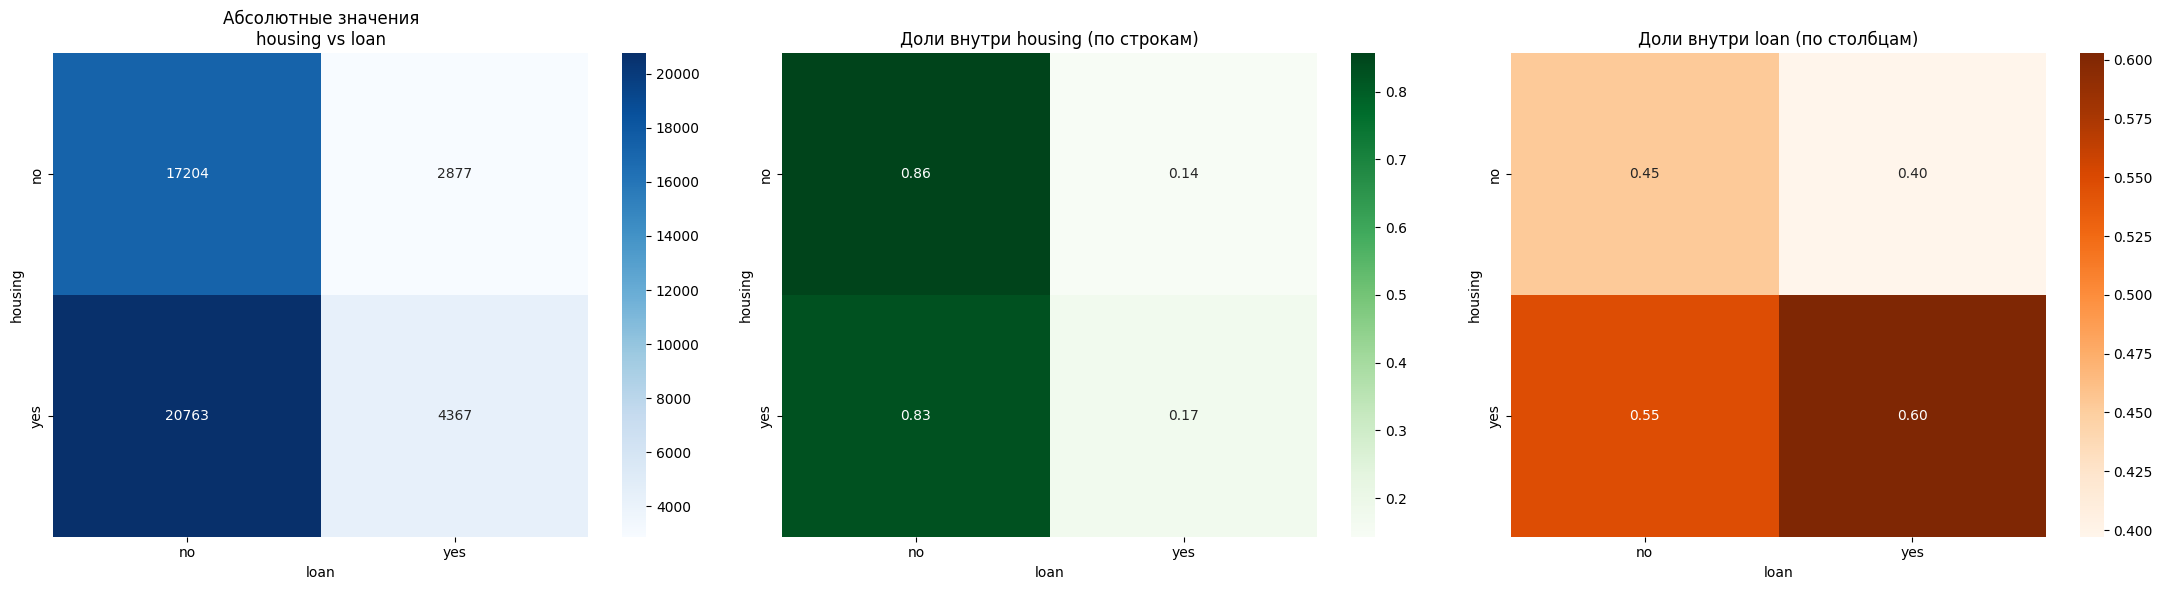

loan,no,yes
housing,,
no,0.857,0.143
yes,0.826,0.174


Комментарий: среди имеющих ипотеку (housing=yes) потребкредит есть в 17%, среди без ипотеки — 14%.


In [47]:
plot_categorical_relationship(df, 'housing', 'loan')

tab = pd.crosstab(df['housing'], df['loan'], normalize='index').round(3)
display(tab)

def pc(x): return f"{x*100:.0f}%"
if {'yes','no'}.issubset(tab.columns):
    print("Комментарий:",
          f"среди имеющих ипотеку (housing=yes) потребкредит есть в {pc(tab.loc['yes','yes'])},",
          f"среди без ипотеки — {pc(tab.loc['no','yes'])}.")


month vs y (сезонность конверсии)

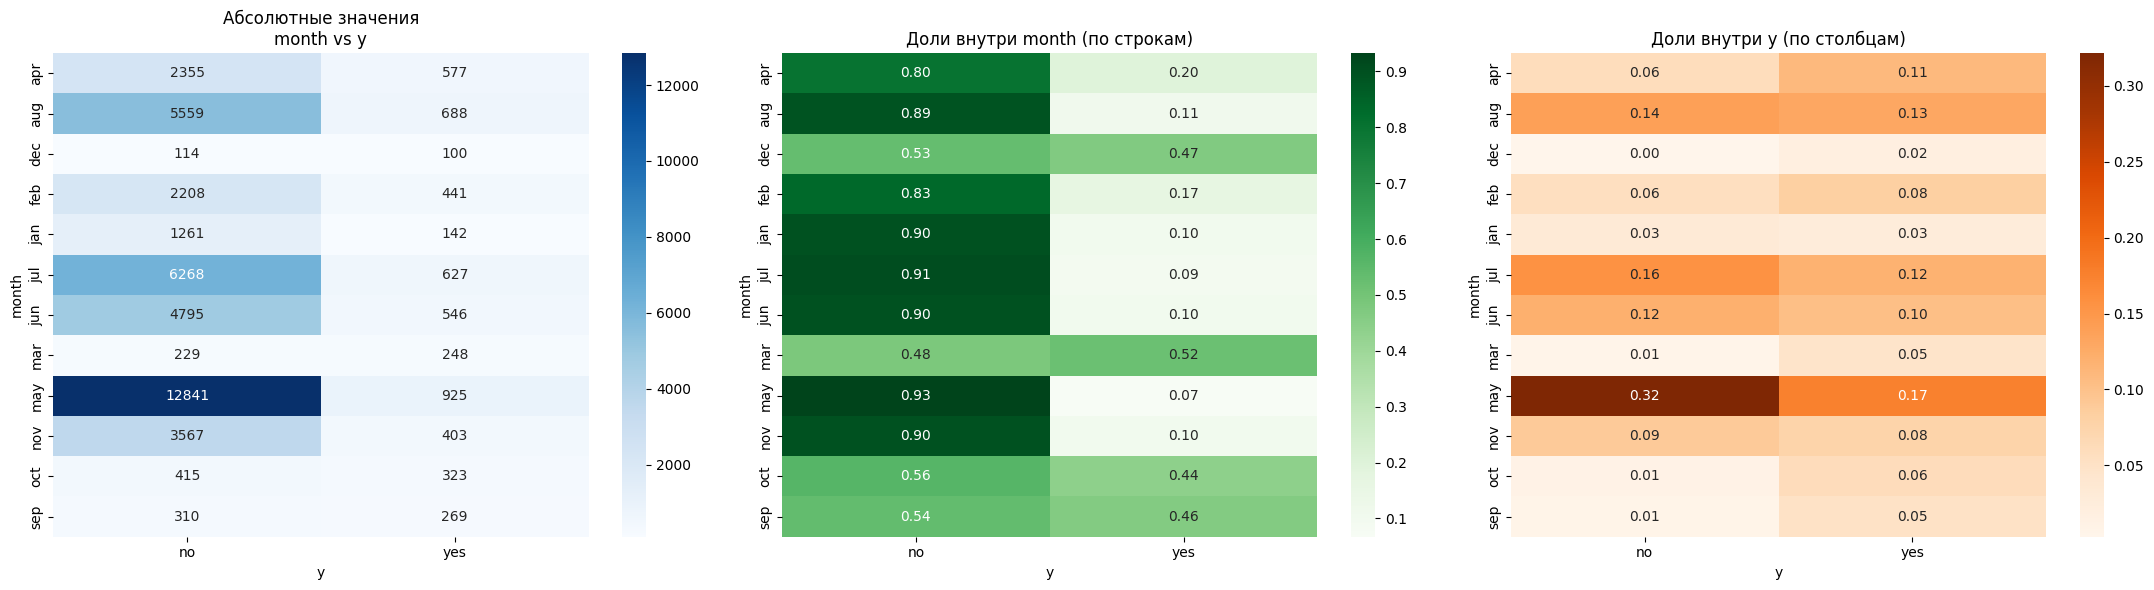

y,no,yes
month,,
apr,0.803,0.197
aug,0.890,0.110
dec,0.533,0.467
feb,0.834,0.166
jan,0.899,0.101
jul,0.909,0.091
jun,0.898,0.102
mar,0.480,0.520
may,0.933,0.067


Комментарий: месяцы с наибольшей конверсией: mar (52%), dec (47%), sep (46%) | наименьшая: may (7%), jul (9%), jan (10%)


In [48]:
plot_categorical_relationship(df, 'month', 'y')

tab = pd.crosstab(df['month'], df['y'], normalize='index').round(3)
display(tab)

if 'yes' in tab.columns:
    best = tab['yes'].sort_values(ascending=False).head(3)
    worst = tab['yes'].sort_values(ascending=True).head(3)
    print("Комментарий:",
          "месяцы с наибольшей конверсией:", ", ".join([f"{m} ({v*100:.0f}%)" for m,v in best.items()]),
          "| наименьшая:", ", ".join([f"{m} ({v*100:.0f}%)" for m,v in worst.items()]))


contact vs y (влияние канала на исход)

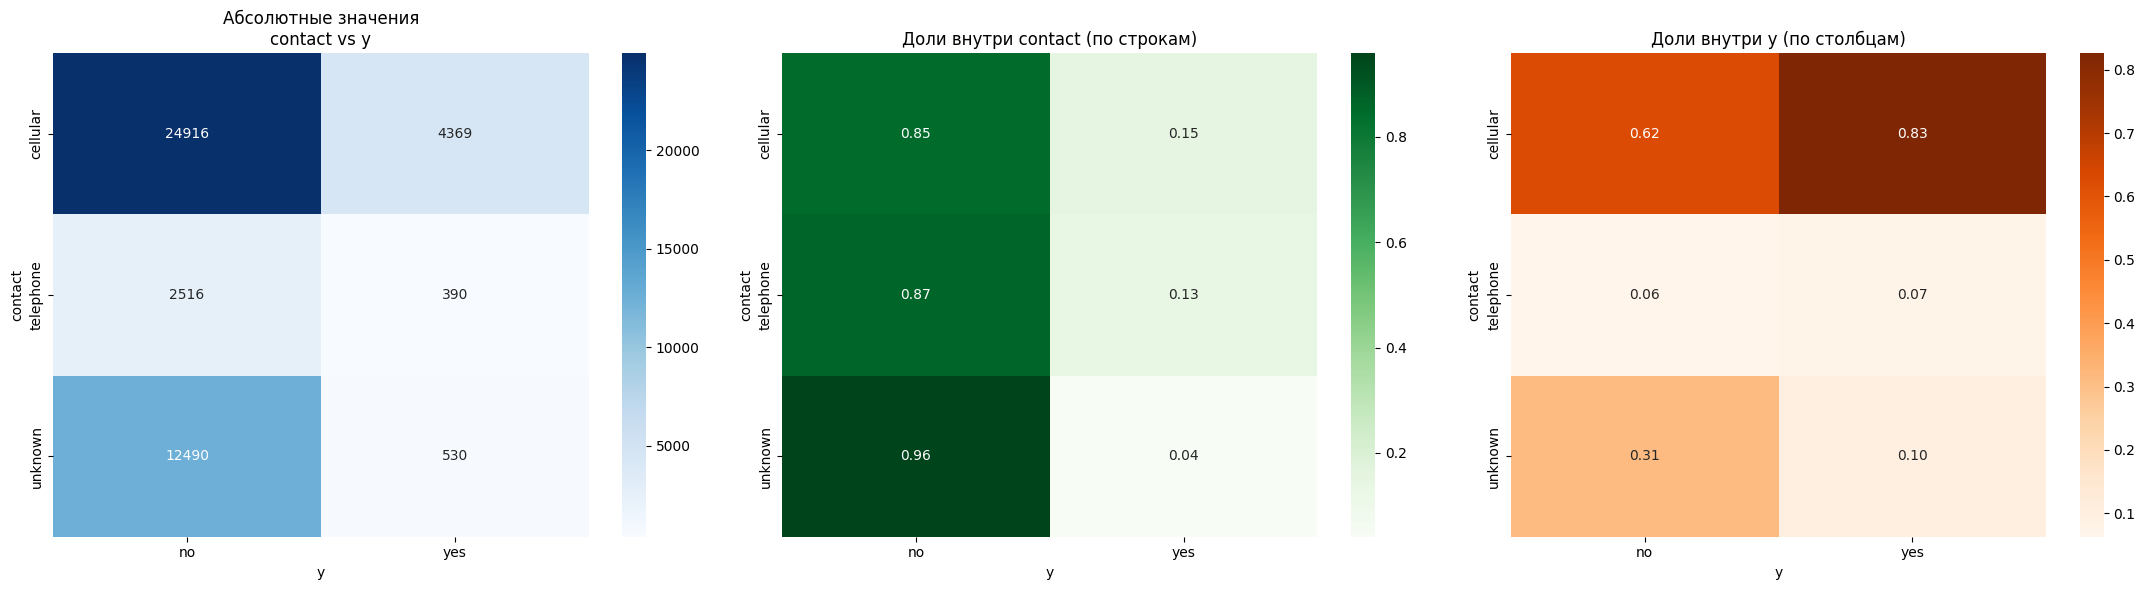

y,no,yes
contact,,
cellular,0.851,0.149
telephone,0.866,0.134
unknown,0.959,0.041


Комментарий: доли подписок по каналам: cellular=15%, telephone=13%, unknown=4%


In [49]:
plot_categorical_relationship(df, 'contact', 'y')

tab = pd.crosstab(df['contact'], df['y'], normalize='index').round(3)
display(tab)

if 'yes' in tab.columns:
    print("Комментарий:",
          "доли подписок по каналам:",
          ", ".join([f"{idx}={val*100:.0f}%" for idx,val in tab['yes'].items()]))


duration vs campaign

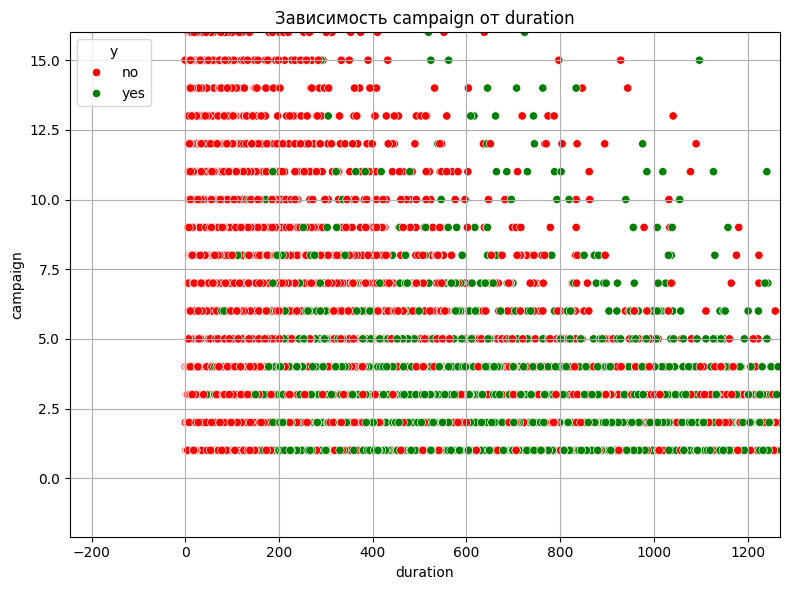

Pearson=-0.08, Spearman=-0.11


In [50]:
xq = np.nanquantile(df['duration'], 0.99)
yq = np.nanquantile(df['campaign'], 0.99)

plot_numeric_relationship(
    df, 'duration', 'campaign',
    x_max=float(xq), y_max=float(yq),
    target_col='y', target_colors={'yes':'green','no':'red'}
)

corr_pear = df[['duration','campaign']].corr(numeric_only=True).iloc[0,1]
corr_spear = df[['duration','campaign']].corr(method='spearman', numeric_only=True).iloc[0,1]
print(f"Pearson={corr_pear:.2f}, Spearman={corr_spear:.2f}")

линейной зависимости campaign от duration нет. Зато по цвету видно, что большая duration чаще ассоциирована с y=yes — признак потенциальной утечки, его будем исключать из «честных» моделей.

pdays vs previous (без -1)

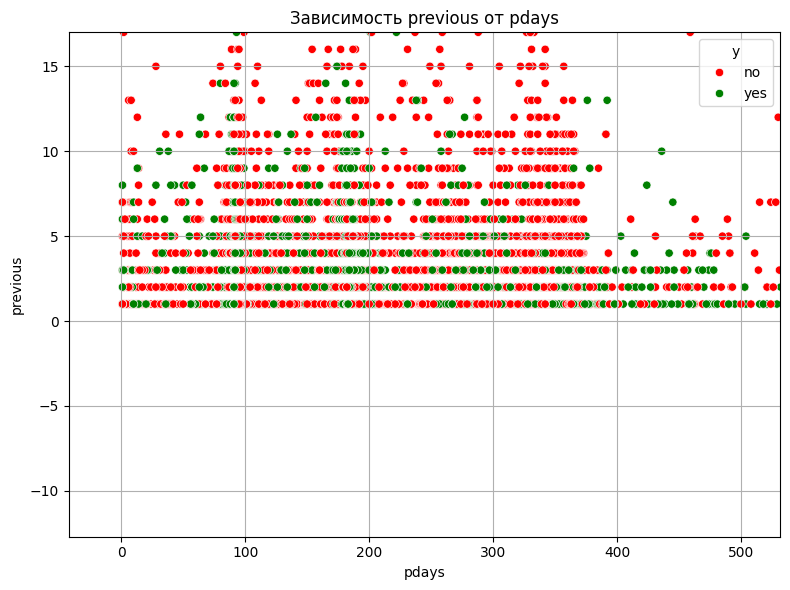

Pearson≈-0.02


In [51]:
mask = df['pdays'] != -1
xq = np.nanquantile(df.loc[mask,'pdays'], 0.99)
yq = np.nanquantile(df.loc[mask,'previous'], 0.99)

plot_numeric_relationship(
    df.loc[mask], 'pdays', 'previous',
    x_max=float(xq), y_max=float(yq),
    target_col='y', target_colors={'yes':'green','no':'red'}
)

c = df.loc[mask, ['pdays','previous']].corr(numeric_only=True).iloc[0,1]
print(f"Pearson≈{c:.2f}")


Без специальных значений −1 линейная связь практически отсутствует. Сильная зависимость на общей теплокарте обусловлена структурной парой pdays=−1 и previous=0 (клиент не контактировался ранее).

age vs balance (финансовый профиль)

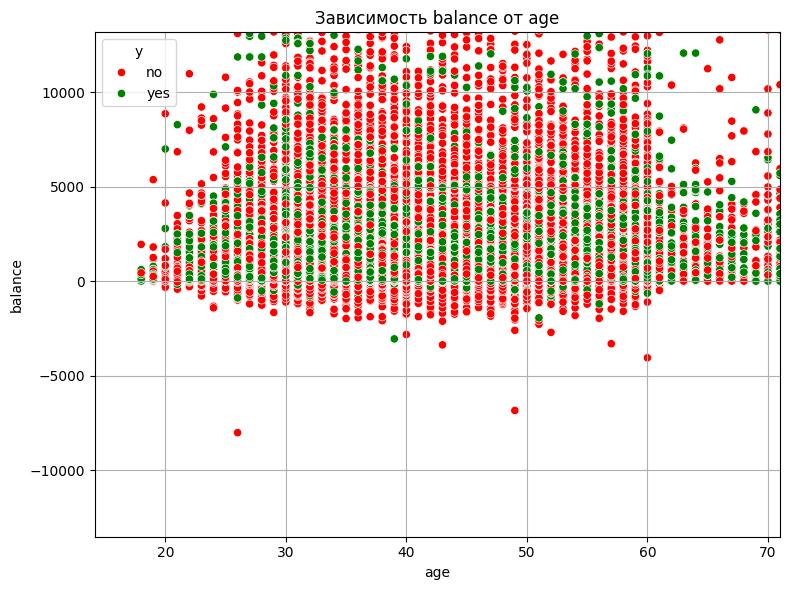

Pearson≈0.10


In [52]:
xq = np.nanquantile(df['age'], 0.99)
yq = np.nanquantile(df['balance'], 0.99)

plot_numeric_relationship(
    df, 'age', 'balance',
    x_max=float(xq), y_max=float(yq),
    target_col='y', target_colors={'yes':'green','no':'red'}
)

c = df[['age','balance']].corr(numeric_only=True).iloc[0,1]
print(f"Pearson≈{c:.2f}")


Корреляция слабая. Из-за тяжёлых хвостов balance полезны робастные трансформации (например, signed-log sign(x)*log1p(|x|) или RobustScaler) и клиппинг верхних перцентилей.

## 5. Препроцессинг данных
Препроцессинг данных можно разделить на **две основные категории**:
1. **Общие преобразования** – применяются ко всему датасету до разделения на train и test.
2. **Индивидуальные преобразования** – выполняются отдельно для тренировочной и тестовой выборок.

## Почему такое разделение необходимо?

Некоторые преобразования требуют **расчета статистик** (например, замена пропусков медианой, стандартизация, частотное кодирование) или даже **обучения вспомогательных моделей** (например, KNN для импутации пропущенных значений). Если применить такие преобразования ко всему датасету **до** разделения, это приведет к **data leakage** (утечке данных).

### Как избежать утечки данных?

1. **Сначала разделять данные** на train и test (или использовать кросс-валидацию).
2. **Обучать preprocessing-алгоритмы** (импутеры, энкодеры, скейлеры) **только на train**.
3. **Применять обученные преобразования** к test, **без пересчета статистик**.

Для удобства можно использовать **пайплайны** (например, `sklearn.pipeline.Pipeline`), которые автоматически следят за корректным порядком преобразований.

## Какие преобразования можно применять ко всему датасету?

Те, что **не зависят от статистик** и не требуют обучения:
- Удаление дубликатов.
- Исправление очевидных аномалий (например, отрицательный возраст).
- Разовые преобразования (изменение формата даты, переименование столбцов).
- Фильтрация строк/столбцов, не связанная с целевой переменной.

Такой подход помогает **избежать дублирования кода**, сохраняя при этом валидность эксперимента.

### 5.1 Общие преобразования

In [6]:
df_preprocessed = df.copy()

In [7]:
num_cols = ['age','balance','day','duration','campaign','pdays','previous']
for c in num_cols:
    df_preprocessed[c] = pd.to_numeric(df_preprocessed[c], errors='coerce')

for c in ['job','marital','education','default','housing','loan','contact','poutcome','month','y']:
    df_preprocessed[c] = df_preprocessed[c].astype('category')

In [8]:
# Упорядочим month
months_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
df_preprocessed['month'] = pd.Categorical(df_preprocessed['month'],
                                          categories=months_order, ordered=True)

In [9]:
# флаг для специального значения pdays == -1
df_preprocessed['pdays_never'] = (df_preprocessed['pdays'] == -1).astype('int8')

In [10]:
print(df_preprocessed.dtypes)
print("\nТаргет (y):")
print(df_preprocessed['y'].value_counts(dropna=False))

print("\nФлаг pdays_never (доля 1):",
      df_preprocessed['pdays'].mean().round(3))

df_preprocessed.head(3)

age               int64
job            category
marital        category
education      category
default        category
balance           int64
housing        category
loan           category
contact        category
day               int64
month          category
duration          int64
campaign          int64
pdays             int64
previous          int64
poutcome       category
y              category
pdays_never        int8
dtype: object

Таргет (y):
y
no     39922
yes     5289
Name: count, dtype: int64

Флаг pdays_never (доля 1): 40.198


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_never
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1


In [11]:
# Кодирование таргета
df_preprocessed['y'] = np.where(df_preprocessed['y'] == 'yes', 1, 0)

In [12]:
df_preprocessed.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_never
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1


### 5.2 Разбиение датасета 

In [140]:
# делим данные на признаки и таргет
X, y = divide_data(df_preprocessed, 'y')

In [ ]:
# Разбиваем данные на train и test с соотношением 80 на 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    shuffle=True 
)

In [142]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pdays_never
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,30,self-employed,single,tertiary,no,137,yes,no,cellular,11,may,214,1,-1,0,unknown,1
36164,54,technician,divorced,secondary,no,1252,yes,no,cellular,11,may,101,1,350,1,failure,0
36165,40,management,married,tertiary,no,-17,yes,yes,cellular,11,may,474,1,256,1,success,0
36166,45,blue-collar,married,unknown,no,-72,yes,no,cellular,11,may,306,1,-1,0,unknown,1


In [143]:
X_train_preprocessed = X_train.copy()
X_test_preprocessed = X_test.copy()

In [144]:
categorical_cols = ['job','marital','education','default','housing','loan',
                    'contact','month','poutcome']
numeric_cols = ['age','balance','day','campaign','pdays','previous','pdays_never']

### 5.3 Кодирование категориальных переменных

In [145]:
# Будем использовать порядковое кодирование. Для этого выпишем все категории для каждого столбца в порядке увеличения номера
cat_orders = [
    # job
    ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
     'retired', 'self-employed', 'services', 'student', 'technician',
     'unemployed', 'unknown'],
    # marital
    ['divorced', 'married', 'single'],
    # education
    ['primary', 'secondary', 'tertiary', 'unknown'],
    # default / housing / loan
    ['no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes'],
    # contact
    ['unknown', 'telephone', 'cellular'],
    # month
    ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    # poutcome
    ['failure', 'other', 'success', 'unknown']
]

In [146]:
encoder = OrdinalEncoder(categories=cat_orders)
X_train_preprocessed[categorical_cols] = encoder.fit_transform(X_train_preprocessed[categorical_cols])

In [147]:
#X_test_preprocessed[categorical_cols]  = encoder.transform(X_test[categorical_cols])

In [148]:
X_train_preprocessed

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,pdays_never
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,0.0,5,4.0,261,1,-1,0,3.0,1
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,0.0,5,4.0,151,1,-1,0,3.0,1
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,0.0,5,4.0,76,1,-1,0,3.0,1
3,47,1.0,1.0,3.0,0.0,1506,1.0,0.0,0.0,5,4.0,92,1,-1,0,3.0,1
4,33,11.0,2.0,3.0,0.0,1,0.0,0.0,0.0,5,4.0,198,1,-1,0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,30,6.0,2.0,2.0,0.0,137,1.0,0.0,2.0,11,4.0,214,1,-1,0,3.0,1
36164,54,9.0,0.0,1.0,0.0,1252,1.0,0.0,2.0,11,4.0,101,1,350,1,0.0,0
36165,40,4.0,1.0,2.0,0.0,-17,1.0,1.0,2.0,11,4.0,474,1,256,1,2.0,0
36166,45,1.0,1.0,3.0,0.0,-72,1.0,0.0,2.0,11,4.0,306,1,-1,0,3.0,1


### 5.3 Итоговый пайплайн для препроцессинга
Для удобства объединим все наши преобразования в единый пайплайн, который можно будет впоследствии переиспользовать на тестовой выборке. Это поможет избежать излишнего копипаста, ошибок и предотваратить data leakage

Мы применяем ColumnTransformer последовательно внутри Pipeline, чтобы:
1. Сначала обработать часть колонок (наиболее частыми значениями)
2. Затем обработать другие колонки (средними значениями)
3. И только после этого выполнить кодирование категориальных признаков

Такой подход гарантирует, что:
- Импутация пропусков завершится до начала кодирования
- Порядок обработки колонок будет соблюден
- Каждый этап получит данные в правильном формате

In [149]:
numeric_cols_no_dur  = ['age','balance','day','campaign','pdays','previous','pdays_never']
numeric_cols_with_dur = numeric_cols_no_dur + ['duration']   # для референса

In [ ]:
# пайплайн
preprocessor_no_dur = Pipeline([
    ('nan_remover', ColumnTransformer(
        transformers=[
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), numeric_cols_no_dur),
            ('most_frequent_cat',    SimpleImputer(strategy='most_frequent'), categorical_cols),
            ('mean',                 SimpleImputer(strategy='mean'),          [])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('transformations', ColumnTransformer(
        [('encoder', OrdinalEncoder(categories=cat_orders), categorical_cols)],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
])

In [161]:
preprocessor_no_dur.set_output(transform='pandas')

,steps,"[('nan_remover', ...), ('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('most_frequent_numeric', ...), ('most_frequent_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [162]:
X_train_preprocessed = preprocessor_no_dur.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, index=X_train.index)

In [163]:
print(X_train_preprocessed.shape, X_test_preprocessed.shape)
X_train_preprocessed.info()

(36168, 17) (9043, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   job          36168 non-null  float64
 1   marital      36168 non-null  float64
 2   education    36168 non-null  float64
 3   default      36168 non-null  float64
 4   housing      36168 non-null  float64
 5   loan         36168 non-null  float64
 6   contact      36168 non-null  float64
 7   month        36168 non-null  float64
 8   poutcome     36168 non-null  float64
 9   age          36168 non-null  int64  
 10  balance      36168 non-null  int64  
 11  day          36168 non-null  int64  
 12  campaign     36168 non-null  int64  
 13  pdays        36168 non-null  int64  
 14  previous     36168 non-null  int64  
 15  pdays_never  36168 non-null  int64  
 16  duration     36168 non-null  int64  
dtypes: float64(9), int64(8)
memory usage: 5.0 MB


In [164]:
# смотрим на результат работы пайплайна
X_train_preprocessed 

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,campaign,pdays,previous,pdays_never,duration
0,4.0,1.0,2.0,0.0,1.0,0.0,0.0,4.0,3.0,58,2143,5,1,-1,0,1,261
1,9.0,2.0,1.0,0.0,1.0,0.0,0.0,4.0,3.0,44,29,5,1,-1,0,1,151
2,2.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,3.0,33,2,5,1,-1,0,1,76
3,1.0,1.0,3.0,0.0,1.0,0.0,0.0,4.0,3.0,47,1506,5,1,-1,0,1,92
4,11.0,2.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,33,1,5,1,-1,0,1,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,6.0,2.0,2.0,0.0,1.0,0.0,2.0,4.0,3.0,30,137,11,1,-1,0,1,214
36164,9.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0,0.0,54,1252,11,1,350,1,0,101
36165,4.0,1.0,2.0,0.0,1.0,1.0,2.0,4.0,2.0,40,-17,11,1,256,1,0,474
36166,1.0,1.0,3.0,0.0,1.0,0.0,2.0,4.0,3.0,45,-72,11,1,-1,0,1,306


## 6. Построение базовой модели (baseline)
Сейчас наша задача построить базовую модель, от которой мы будем отталкиваться в дальнейшем для применения улучшений. Здесь мы намеренно не трогаем большую часть гиперпараметров моделей и оставляем значения по умолчанию. Подбор этих параметров будет осуществляться позже на финальных стадиях. Мы также не совершали преобразований с данными, направленных на улучшение, поскольку пока что нам не с чем сравнивать наш результат. 

In [166]:
# применяем уже обученный пайплайн к тестовой выборке. 
# Очень важно: здесь уже вызываем transform без fit, чтобы не допустить обучения на тестовых данных
X_test_preprocessed = preprocessor_no_dur.transform(X_test)

In [167]:
X_test_preprocessed.isnull().sum()

job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
poutcome       0
age            0
balance        0
day            0
campaign       0
pdays          0
previous       0
pdays_never    0
duration       0
dtype: int64

In [168]:
feature_names = X_test_preprocessed.columns.to_list()

### 6.1 Dummy Classifier
Для начала попробуем использовать глупый классификатор, который всегда предсказывает только самый частый класс и посмотреть на значение метрик. Это даст нам понимание, от какого нижнего порога метрик нам отталкиваться и с чем сравнивать наши модели.

c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


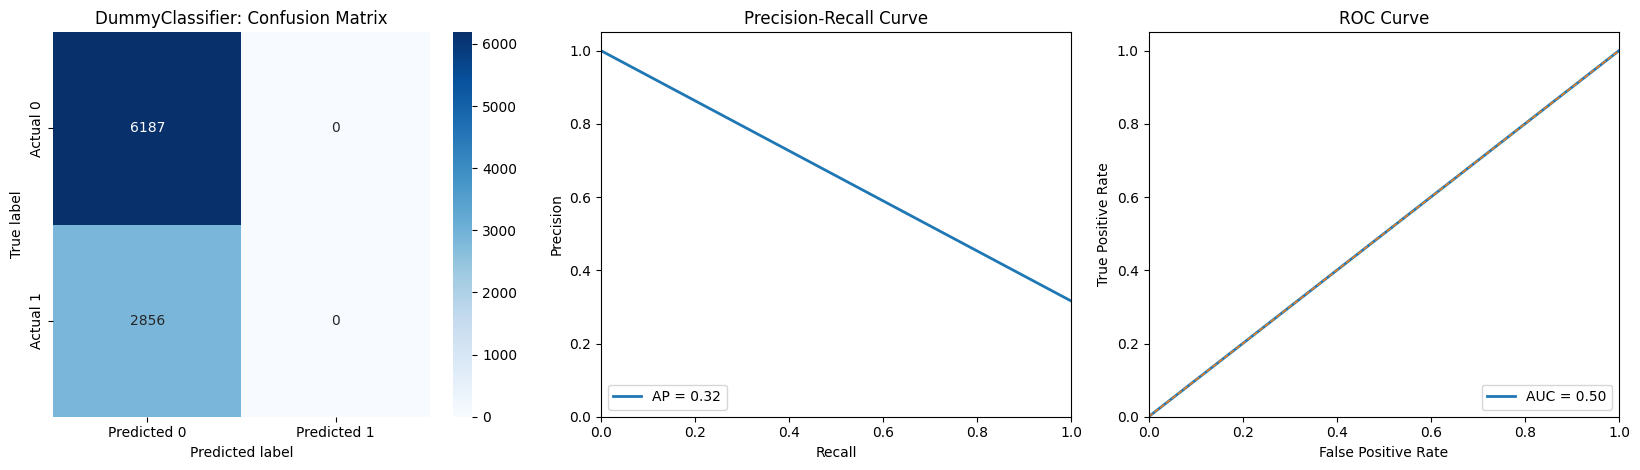


                 DUMMYCLASSIFIER EVALUATION                 

MAIN METRICS:
   Metric  Value
  ROC AUC 0.5000
   PR AUC 0.3158
 F1 Score 0.4062
Precision 0.3421
   Recall 0.5000
 Accuracy 0.6842


CLASSIFICATION REPORT:
   Class  Precision  Recall
Positive   0.000000     0.0
Negative   0.684176     1.0



In [169]:
# Задаем и обучаем модель
dummy_classifier = DummyClassifier(random_state=SEED, strategy='most_frequent')
dummy_classifier.fit(X_train_preprocessed, y_train)

# Получаем предсказания
y_pred = dummy_classifier.predict(X_test_preprocessed) # предсказываем номер класса
y_probs = dummy_classifier.predict_proba(X_test_preprocessed)[:, 1] # предсказываем вероятность (необходима для построения ROC кривой)

# Считаем метрики для модели и выводим графики
dummy_classifier_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="DummyClassifier"
)

### 6.2 Логистическая регрессия

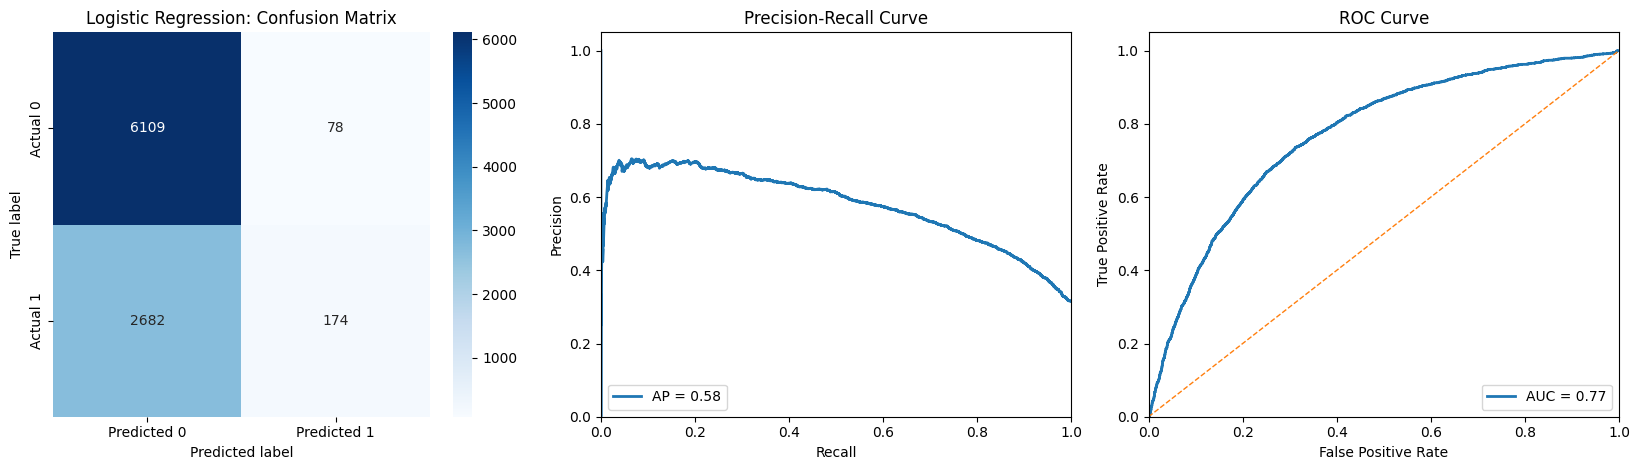


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7702
   PR AUC 0.5780
 F1 Score 0.4638
Precision 0.6927
   Recall 0.5242
 Accuracy 0.6948


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.690476 0.060924
Negative   0.694915 0.987393



In [170]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')
log_reg.fit(X_train_preprocessed, y_train)

y_pred = log_reg.predict(X_test_preprocessed)
y_probs = log_reg.predict_proba(X_test_preprocessed)[:, 1]  

log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression"
)

c:\Users\theea\Documents\GitHub\Bank-Marketing\plots.py:313: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


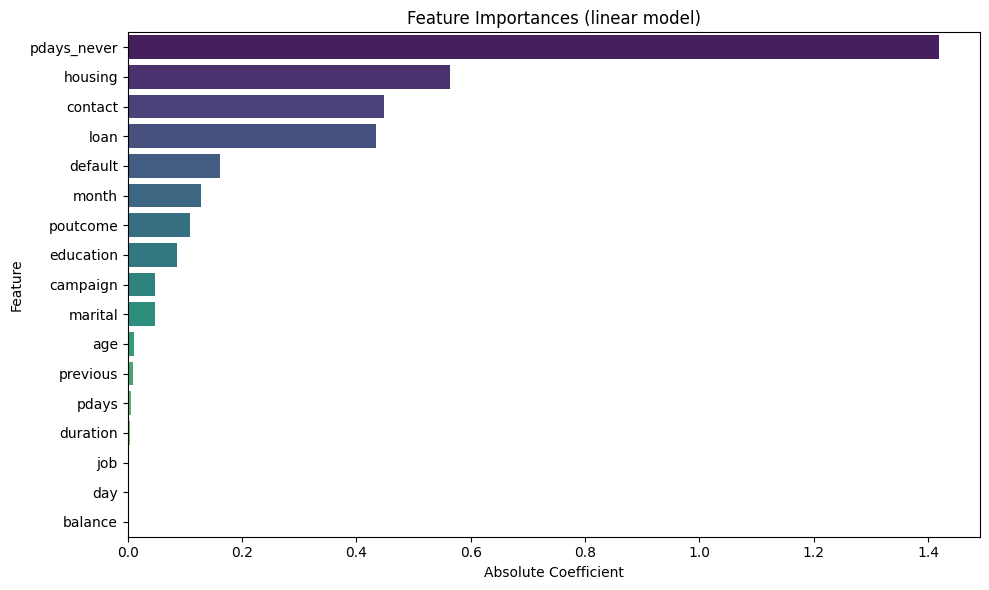

,Feature,Importance
15,pdays_never,1.419762
4,housing,0.563914
6,contact,0.447809
5,loan,0.434220
3,default,0.161073
7,month,0.127822
8,poutcome,0.109487
2,education,0.086826
12,campaign,0.048112
1,marital,0.046950


In [171]:
# Построим гистограмму важностей для каждой фичи
plot_feature_importance(log_reg, feature_names)

Опирается в основном на простые индикаторы.

### 6.3 Дерево решений

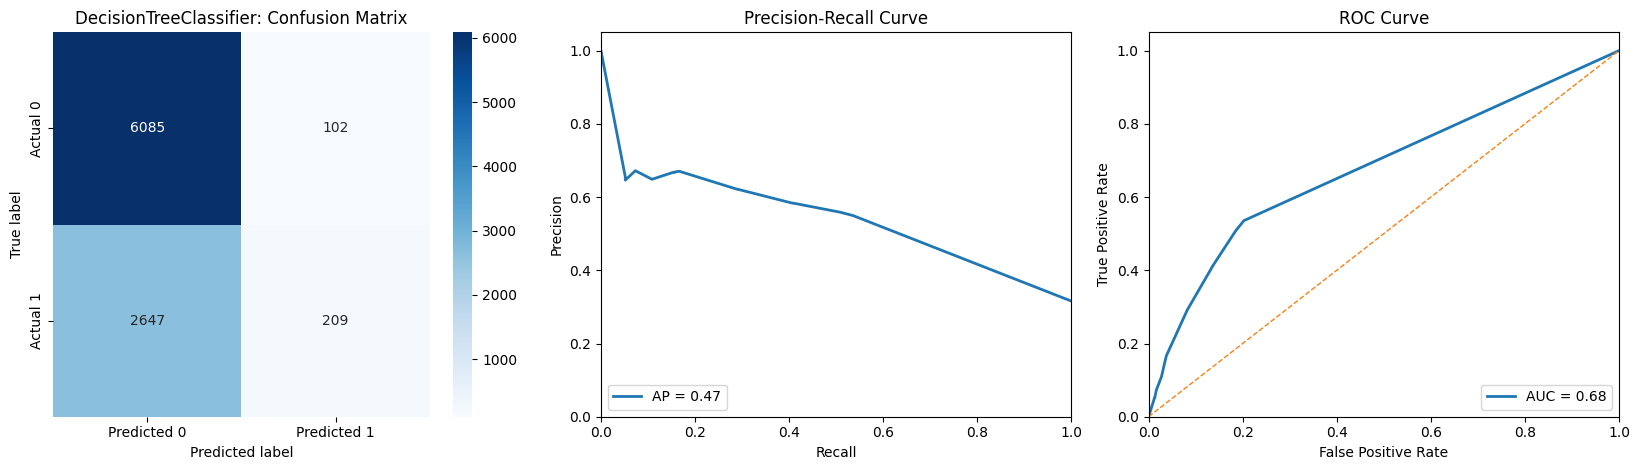


             DECISIONTREECLASSIFIER EVALUATION              

MAIN METRICS:
   Metric  Value
  ROC AUC 0.6760
   PR AUC 0.4732
 F1 Score 0.4739
Precision 0.6844
   Recall 0.5283
 Accuracy 0.6960


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.672026 0.073179
Negative   0.696862 0.983514



In [172]:
decision_tree = DecisionTreeClassifier(random_state=SEED, max_depth=4)
decision_tree.fit(X_train_preprocessed, y_train)

y_pred = decision_tree.predict(X_test_preprocessed)
y_probs = decision_tree.predict_proba(X_test_preprocessed)[:, 1]  # For ROC curve

decision_tree_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="DecisionTreeClassifier"
)

c:\Users\theea\Documents\GitHub\Bank-Marketing\plots.py:313: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


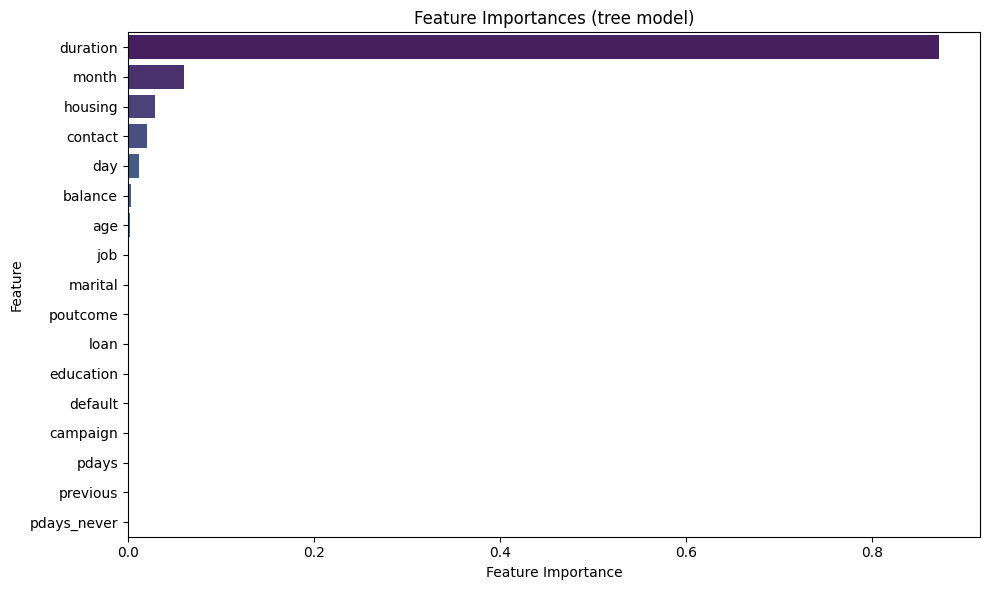

,Feature,Importance
16,duration,0.872071
7,month,0.059919
4,housing,0.029292
6,contact,0.020664
11,day,0.012181
10,balance,0.003601
9,age,0.002273
0,job,0.000000
1,marital,0.000000
8,poutcome,0.000000


In [173]:
plot_feature_importance(decision_tree, feature_names)

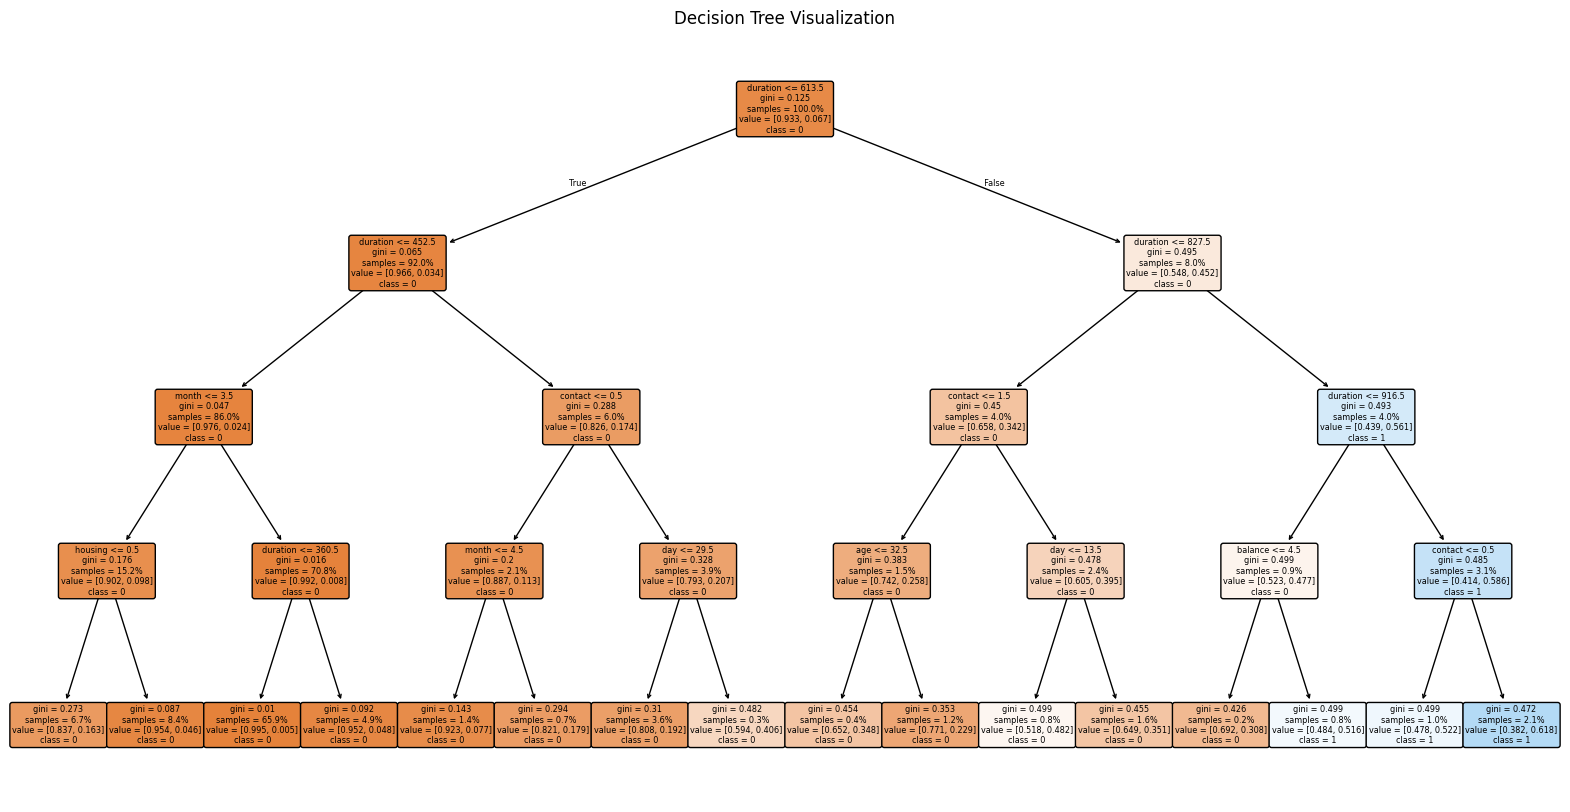

In [77]:
# Визуализируем наше дерево решений
visualize_decision_tree(decision_tree, feature_names, class_names=['0', '1'])

В сценарии «с duration» дерево почти полностью полагается на потенциально утечный признак и из-за этого выглядит «сильным» локально, но будет нереалистично в проде. Для честного сценария обязательно исключать duration

### 6.4 Случайный лес

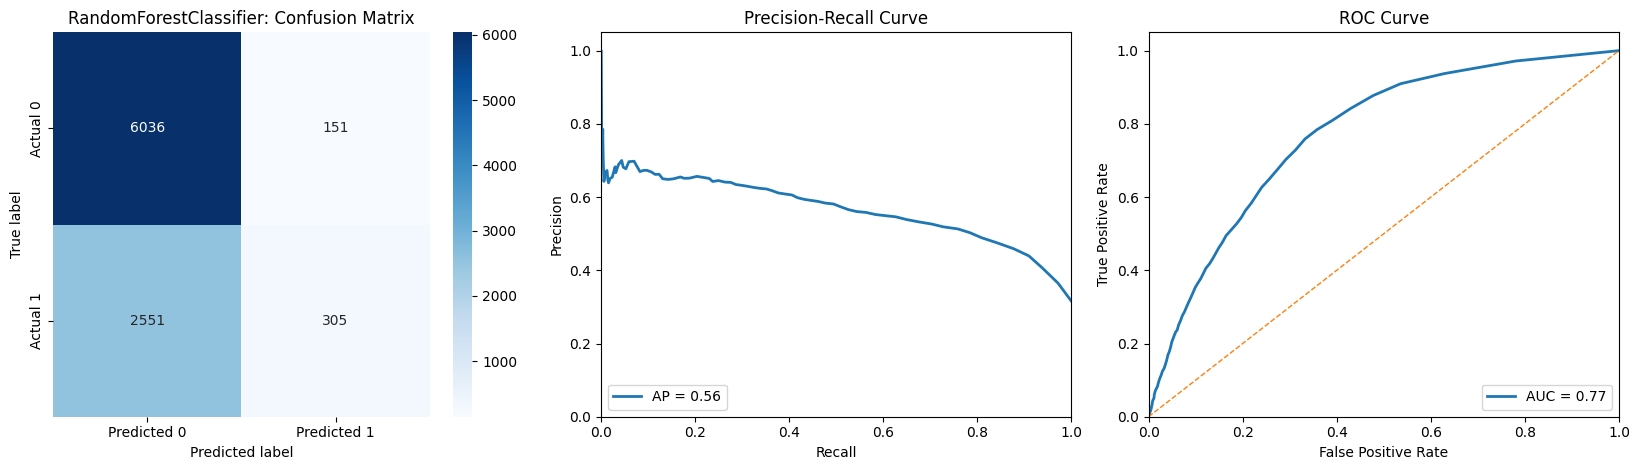


             RANDOMFORESTCLASSIFIER EVALUATION              

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7711
   PR AUC 0.5625
 F1 Score 0.5006
Precision 0.6859
   Recall 0.5412
 Accuracy 0.7012


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.668860 0.106793
Negative   0.702923 0.975594



In [174]:
# Train your model
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train_preprocessed, y_train)

# Get predictions
y_pred = random_forest.predict(X_test_preprocessed)
y_probs = random_forest.predict_proba(X_test_preprocessed)[:, 1]  # For ROC curve

# Evaluate
random_forest_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="RandomForestClassifier"
)

c:\Users\theea\Documents\GitHub\Bank-Marketing\plots.py:313: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


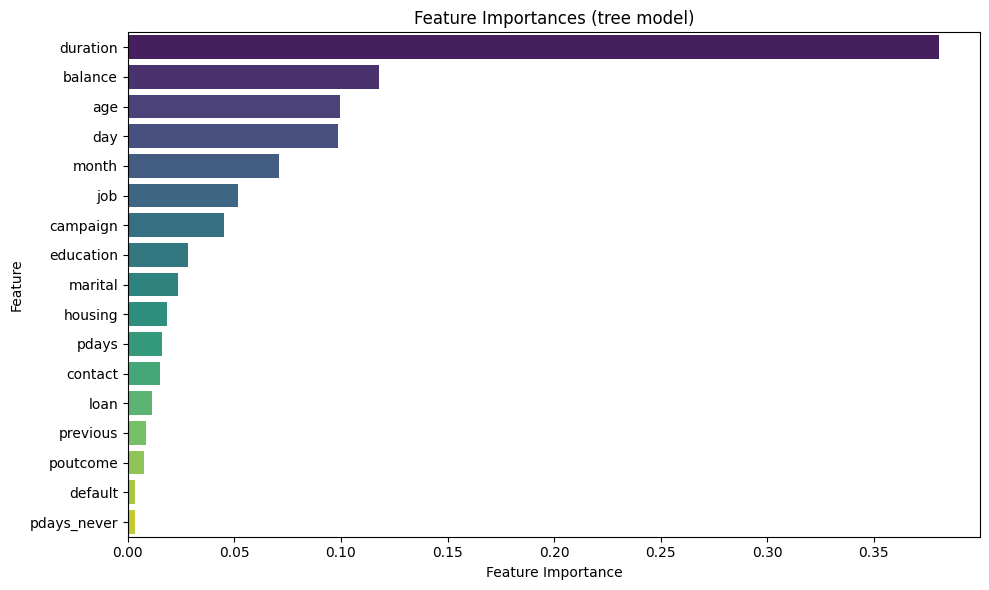

,Feature,Importance
16,duration,0.380775
10,balance,0.118089
9,age,0.099421
11,day,0.098440
7,month,0.070993
0,job,0.051905
12,campaign,0.044920
2,education,0.028270
1,marital,0.023760
4,housing,0.018357


In [175]:
plot_feature_importance(random_forest, feature_names)

Лес работает заметно стабильнее одиночного дерева: меньше шумит и лучше держит отрицательный класс. Если смотреть на важности, он в первую очередь опирается на balance, календарь (day/month), age, а дальше идут признаки профиля клиента — job, campaign, education. Двоичные флаги вроде default/loan/housing почти не влияют, а pdays_never для леса почти пустой сигнал.

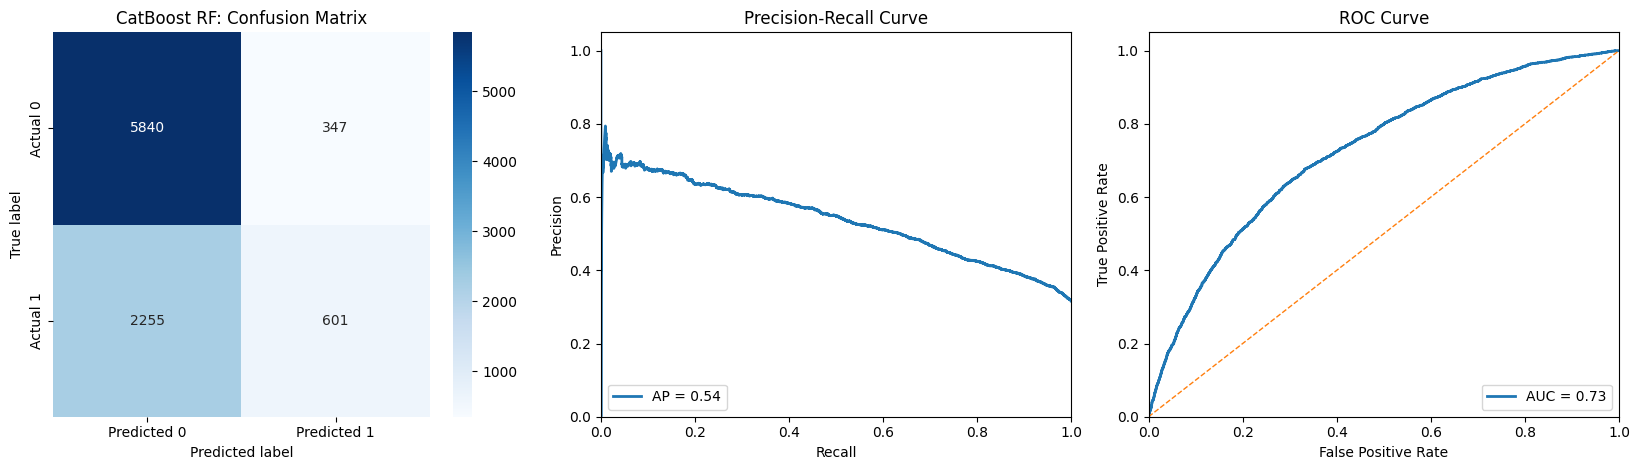


                   CATBOOST RF EVALUATION                   

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7265
   PR AUC 0.5370
 F1 Score 0.5669
Precision 0.6777
   Recall 0.5772
 Accuracy 0.7123


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.633966 0.210434
Negative   0.721433 0.943915



In [176]:
cb_rf = CatBoostClassifier(
    iterations=400,            # число деревьев
    depth=8,                   # глубина деревьев
    learning_rate=1.0,         # для RF-режима — независимые деревья
    loss_function='Logloss',
    bootstrap_type='Bernoulli',# бэггинг по объектам (как в RF)
    subsample=0.632,           # 63.2% сэмплов на дерево
    rsm=0.8,                   # feature subsampling (аналог max_features)
    random_state=SEED,
    verbose=0,
    allow_writing_files=False
)

# fit / predict
cb_rf.fit(X_train_preprocessed, y_train)
y_pred  = cb_rf.predict(X_test_preprocessed).astype(int)
y_probs = cb_rf.predict_proba(X_test_preprocessed)[:, 1]

# оценка
cb_rf_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="CatBoost RF"
)

### 6.5 Градиентный бустинг

[LightGBM] [Info] Number of positive: 2433, number of negative: 33735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067269 -> initscore=-2.629411
[LightGBM] [Info] Start training from score -2.629411


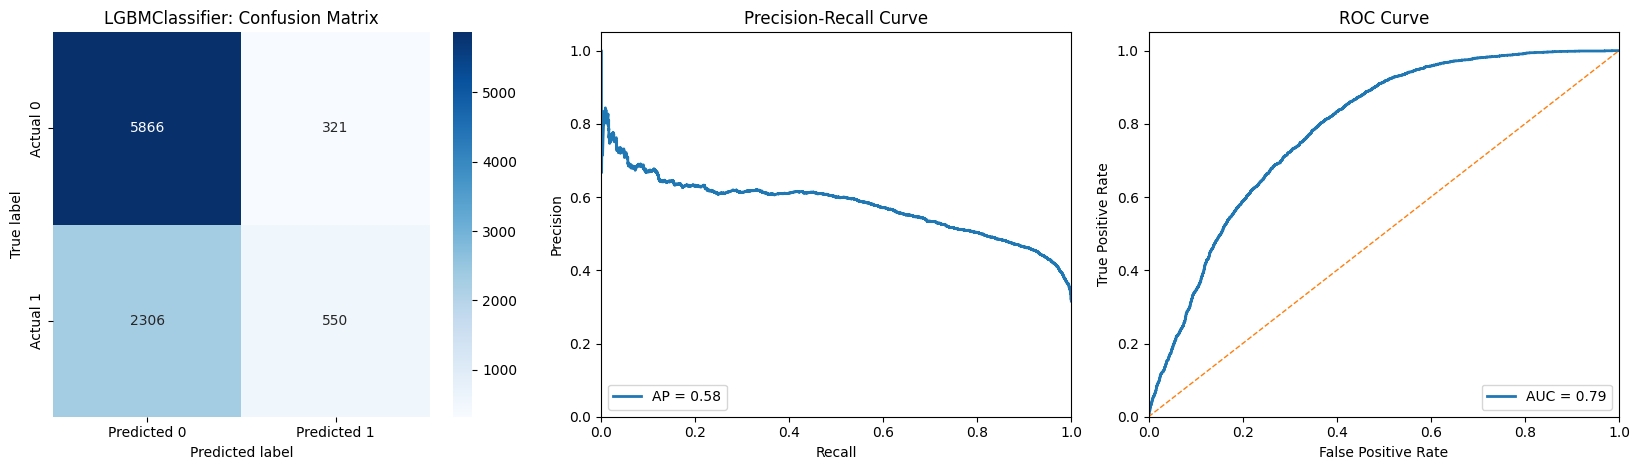


                 LGBMCLASSIFIER EVALUATION                  

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7871
   PR AUC 0.5780
 F1 Score 0.5561
Precision 0.6746
   Recall 0.5703
 Accuracy 0.7095


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.631458 0.192577
Negative   0.717817 0.948117



In [177]:
# Train your model
lgbm = LGBMClassifier(random_state=SEED)
lgbm.fit(X_train_preprocessed, y_train)

# Get predictions
y_pred = lgbm.predict(X_test_preprocessed)
y_probs = lgbm.predict_proba(X_test_preprocessed)[:, 1]  # For ROC curve

# Evaluate
lgbm_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="LGBMClassifier"
)

c:\Users\theea\Documents\GitHub\Bank-Marketing\plots.py:313: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


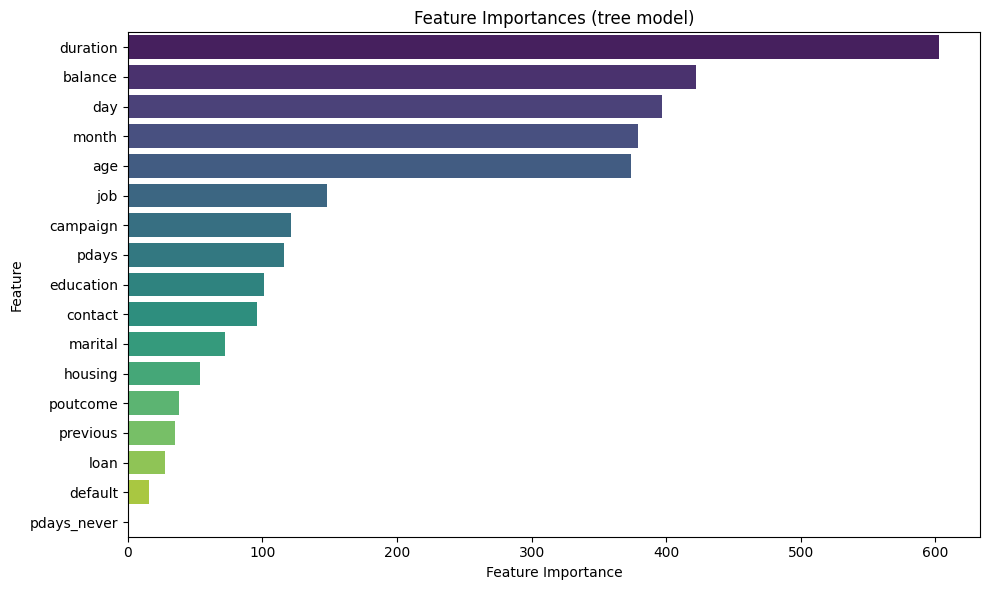

,Feature,Importance
16,duration,603
10,balance,422
11,day,397
7,month,379
9,age,374
0,job,148
12,campaign,121
13,pdays,116
2,education,101
6,contact,96


In [178]:
plot_feature_importance(lgbm, feature_names)

Бустинг выжимает ещё чуть больше пользы. По важностям картина близкая, но вклад поведенческих и календарных признаков сильнее: balance, day/month, age, job, campaign, pdays, education — в топе. Хвост (previous, loan, default, pdays_never) почти не используется. Модель положительных ловит больше при схожем уровне ошибок.

### 6.6 Финальное сравнение метрик

In [179]:
final_metrics = {
    'dummy_classifier': dummy_classifier_metrics,
    'log_reg': log_reg_metrics,
    'decision_tree': decision_tree_metrics,
    'random_forest': random_forest_metrics,
    'lgbm': lgbm_metrics
}

result = pd.DataFrame(final_metrics.values(), index=final_metrics.keys())

In [180]:
result

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy,PR Curve
dummy_classifier,0.500000,0.315824,0.406238,0.342088,0.500000,0.684176,"{'precision': [0.31582439455932765, 1.0], 'rec..."
log_reg,0.770184,0.577982,0.463849,0.692696,0.524159,0.694792,"{'precision': [0.31582439455932765, 0.31585932..."
decision_tree,0.676037,0.473215,0.473862,0.684444,0.528347,0.696008,"{'precision': [0.31582439455932765, 0.54956896..."
random_forest,0.771052,0.562532,0.500645,0.685891,0.541193,0.701205,"{'precision': [0.31582439455932765, 0.36498750..."
lgbm,0.787096,0.577954,0.556096,0.674638,0.570347,0.709499,"{'precision': [0.31582439455932765, 0.31585932..."


<Axes: >

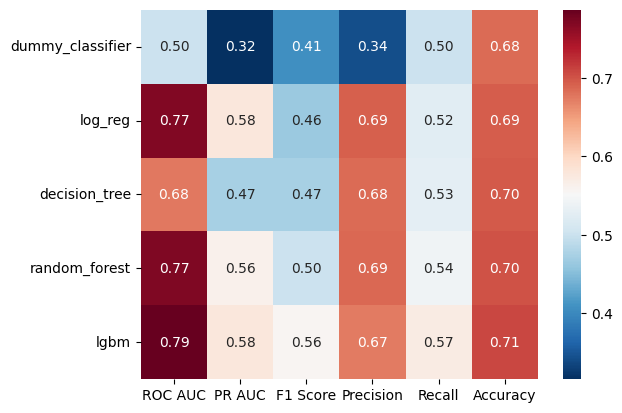

In [181]:
# соберём итоговую таблицу только из нужных числовых метрик
wanted = ['ROC AUC', 'PR AUC', 'F1 Score', 'Precision', 'Recall', 'Accuracy']

result = pd.DataFrame(
    [{k: m.get(k) for k in wanted} for m in final_metrics.values()],
    index=final_metrics.keys()
)
sns.heatmap(result, cmap='RdBu_r', annot=True, fmt=".2f")

большой разницы между точностью моделей нет, поэтому выбор можно сделать на основе других факторов: оптимальный выбор фич, интерпретируемость, скорость обучения и инференса